In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns
import pandas as pd
import tensorflow as tf
import time
sns.set()

In [2]:
dataset_original = pd.read_csv('breast_ori.csv', header = None)

label_dataset = dataset_original.iloc[-1]
dataset_original = dataset_original.iloc[:-1, 1:]

for i in xrange(dataset_original.shape[1]):
    dataset_original.iloc[:, i] = pd.to_numeric(dataset_original.iloc[:, i], errors='coerce')
    low = np.nanmin(dataset_original.iloc[:, i].values)
    high = np.nanmax(dataset_original.iloc[:, i].values)
    dataset_original.iloc[:, i] = dataset_original.iloc[:, i].fillna((low + high) / 2.0)

In [3]:
from sklearn.preprocessing import LabelEncoder
label_dataset = label_dataset.iloc[1:].values
label = np.unique(label_dataset)
label_dataset = LabelEncoder().fit_transform(label_dataset)
dataset_original = dataset_original.iloc[:, :].values.T

In [4]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Normalizer
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

X_original = StandardScaler().fit_transform(dataset_original)
X_original = Normalizer().fit_transform(X_original)
X_original = PCA(n_components = 2).fit_transform(X_original)

Here I will explained generally about activation functions, loss function and gradient descent I used in neural network.

use Adaptive Momentum for gradient descent during back-propagation, a method for stochastic optimization, can read related paper [here](https://arxiv.org/abs/1412.6980)

Tanh function because our data population populated on negative side.
This hyperbolic tangent should help us to squash our data become between (-1, 1) not included.

![alt text](http://mathworld.wolfram.com/images/interactive/TanhReal.gif)
![alt text](https://wikimedia.org/api/rest_v1/media/math/render/svg/d8867d2c297e8da5c841c9e1cae4eef68e38d5dc)
![alt text](https://wikimedia.org/api/rest_v1/media/math/render/svg/a3bf8ceb6b9a3497f51e6787fab89997ef325d59)


ReLu function to introduce non-negative side for out population and smoothing our regression line.
![alt text](https://i.stack.imgur.com/8CGlM.png)
![alt text](https://wikimedia.org/api/rest_v1/media/math/render/svg/5fa5d3598751091eed580bd9dca873f496a2d0ac)


Softmax used for last activation function to get probability distribution for the output.
![alt text](https://upload.wikimedia.org/wikipedia/commons/thumb/b/b5/SigmoidFunction.png/400px-SigmoidFunction.png)
![alt text](https://wikimedia.org/api/rest_v1/media/math/render/svg/e348290cf48ddbb6e9a6ef4e39363568b67c09d3)

Below is settings for Deep Neural Network

In [5]:
input_shape = X_original.shape[1]
learning_rate = 0.001
output_shape = np.unique(label_dataset).shape[0]
split_test = 0.1

# train for 100 iteration
epoch = 10000

output_entropy = np.zeros((label_dataset.shape[0], output_shape), dtype = np.float32)
for i in xrange(label_dataset.shape[0]):
    output_entropy[i][label_dataset[i]] = 1.0
    
X_train, X_test, Y_train, Y_test = train_test_split(X_original, output_entropy, test_size = split_test)

X_train = X_train.astype(np.float32)
X_test = X_test.astype(np.float32)

Below is 3 layers of Neural Network, [97, 2] (TanH)-> [2, 32] (softmax)-> [32, 2]

In [6]:
X = tf.placeholder(tf.float32, [None, input_shape])
Y = tf.placeholder(tf.float32, [None, output_shape])

three_layer_input_layer = tf.Variable(tf.random_normal([input_shape, 32]))
three_layer_bias_input = tf.Variable(tf.random_normal([32], stddev = 0.1))

three_layer_hidden_layer = tf.Variable(tf.random_normal([32, output_shape]))
three_layer_bias_hidden = tf.Variable(tf.random_normal([output_shape], stddev = 0.1))

three_layer_backpropagate = [three_layer_input_layer, three_layer_hidden_layer]

three_layer_feed_1 = tf.nn.tanh(tf.matmul(X, three_layer_input_layer) + three_layer_bias_input)
three_layer_feed_2 = tf.matmul(three_layer_feed_1, three_layer_hidden_layer) + three_layer_bias_hidden

three_layer_cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(three_layer_feed_2, Y))
three_layer_optimizer = tf.train.AdamOptimizer(learning_rate).minimize(three_layer_cost, var_list = three_layer_backpropagate)

three_layer_correct_prediction = tf.equal(tf.argmax(three_layer_feed_2, 1), tf.argmax(Y, 1))
three_layer_accuracy = tf.reduce_mean(tf.cast(three_layer_correct_prediction, "float"))

sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

print "Train for " + str(epoch) + " iteration"

lasttime = time.time()

for i in xrange(epoch):
    _, loss = sess.run([three_layer_optimizer, three_layer_cost], feed_dict = {X: X_train, Y: Y_train})
    acc = sess.run(three_layer_accuracy, feed_dict = {X: X_train, Y: Y_train})
    
    if (i + 1) % 1000 == 0:
        print 'current epoch: ' + str(i + 1) + ' loss: ' + str(loss) + ' accuracy: ' + str(acc)

print "time taken to train(seconds): " + str(time.time() - lasttime)
print "Testing for " + str(Y_test.shape[0]) + " samples"
accuracy_3layers = sess.run(three_layer_accuracy, feed_dict = {X: X_test, Y: Y_test})
print accuracy_3layers

Train for 10000 iteration
current epoch: 1000 loss: 0.606818 accuracy: 0.666667
current epoch: 2000 loss: 0.588798 accuracy: 0.666667
current epoch: 3000 loss: 0.554565 accuracy: 0.678161
current epoch: 4000 loss: 0.532486 accuracy: 0.678161
current epoch: 5000 loss: 0.523462 accuracy: 0.678161
current epoch: 6000 loss: 0.516627 accuracy: 0.701149
current epoch: 7000 loss: 0.511515 accuracy: 0.724138
current epoch: 8000 loss: 0.506861 accuracy: 0.724138
current epoch: 9000 loss: 0.50078 accuracy: 0.747126
current epoch: 10000 loss: 0.491986 accuracy: 0.758621
time taken to train(seconds): 9.34532594681
Testing for 10 samples
0.6


Below is 4 layers of Neural Network, [97, 2] (TanH)-> [2, 64] (ReLu)-> [64, 8] (softmax)-> [8, 2]

In [7]:
four_layer_input_layer = tf.Variable(tf.random_normal([input_shape, 64]))
four_layer_bias_input = tf.Variable(tf.random_normal([64], stddev = 0.1))

four_layer_hidden_layer_1 = tf.Variable(tf.random_normal([64, 8]))
four_layer_bias_hidden_1 = tf.Variable(tf.random_normal([8], stddev = 0.1))

four_layer_hidden_layer_2 = tf.Variable(tf.random_normal([8, output_shape]))
four_layer_bias_hidden_2 = tf.Variable(tf.random_normal([output_shape], stddev = 0.1))

four_layer_backpropagate = [four_layer_input_layer, four_layer_hidden_layer_1, four_layer_hidden_layer_2]

four_layer_feed_1 = tf.nn.tanh(tf.matmul(X, four_layer_input_layer) + four_layer_bias_input)
four_layer_feed_2 = tf.nn.relu(tf.matmul(four_layer_feed_1, four_layer_hidden_layer_1) + four_layer_bias_hidden_1)
four_layer_feed_3 = tf.matmul(four_layer_feed_2, four_layer_hidden_layer_2) + four_layer_bias_hidden_2

four_layer_cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(four_layer_feed_3, Y))
four_layer_optimizer = tf.train.AdamOptimizer(learning_rate).minimize(four_layer_cost, var_list = four_layer_backpropagate)

four_layer_correct_prediction = tf.equal(tf.argmax(four_layer_feed_3, 1), tf.argmax(Y, 1))
four_layer_accuracy = tf.reduce_mean(tf.cast(four_layer_correct_prediction, "float"))

sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

print "Train for " + str(epoch) + " iteration"

lasttime = time.time()

for i in xrange(epoch):
    _, loss = sess.run([four_layer_optimizer, four_layer_cost], feed_dict = {X: X_train, Y: Y_train})
    acc = sess.run(four_layer_accuracy, feed_dict = {X: X_train, Y: Y_train})
    
    if (i + 1) % 1000 == 0:
        print 'current epoch: ' + str(i + 1) + ' loss: ' + str(loss) + ' accuracy: ' + str(acc)
        
print "time taken to train(seconds): " + str(time.time() - lasttime)
print "Testing for " + str(Y_test.shape[0]) + " samples"
accuracy_4layers = sess.run(four_layer_accuracy, feed_dict = {X: X_test, Y: Y_test})
print accuracy_4layers

Train for 10000 iteration
current epoch: 1000 loss: 0.546031 accuracy: 0.666667
current epoch: 2000 loss: 0.53681 accuracy: 0.643678
current epoch: 3000 loss: 0.524586 accuracy: 0.689655
current epoch: 4000 loss: 0.503546 accuracy: 0.712644
current epoch: 5000 loss: 0.475997 accuracy: 0.735632
current epoch: 6000 loss: 0.446193 accuracy: 0.747126
current epoch: 7000 loss: 0.418842 accuracy: 0.758621
current epoch: 8000 loss: 0.383851 accuracy: 0.793103
current epoch: 9000 loss: 0.340438 accuracy: 0.827586
current epoch: 10000 loss: 0.317067 accuracy: 0.83908
time taken to train(seconds): 10.2386460304
Testing for 10 samples
0.6


Below is 5 layers of Neural Network, [97, 2] (TanH)-> [2, 128] (ReLu)-> [128, 64] (ReLu)-> [64, 8] (softmax) -> [8, 2]

In [8]:
five_layer_input_layer = tf.Variable(tf.random_normal([input_shape, 128]))
five_layer_bias_input = tf.Variable(tf.random_normal([128], stddev = 0.1))

five_layer_hidden_layer_1 = tf.Variable(tf.random_normal([128, 64]))
five_layer_bias_hidden_1 = tf.Variable(tf.random_normal([64], stddev = 0.1))

five_layer_hidden_layer_2 = tf.Variable(tf.random_normal([64, 8]))
five_layer_bias_hidden_2 = tf.Variable(tf.random_normal([8], stddev = 0.1))

five_layer_hidden_layer_3 = tf.Variable(tf.random_normal([8, output_shape]))
five_layer_bias_hidden_3 = tf.Variable(tf.random_normal([output_shape], stddev = 0.1))

five_layer_backpropagate = [five_layer_input_layer, five_layer_hidden_layer_1, five_layer_hidden_layer_2, five_layer_hidden_layer_3]

five_layer_feed_1 = tf.nn.tanh(tf.matmul(X, five_layer_input_layer) + five_layer_bias_input)
five_layer_feed_2 = tf.nn.relu(tf.matmul(five_layer_feed_1, five_layer_hidden_layer_1) + five_layer_bias_hidden_1)
five_layer_feed_3 = tf.nn.relu(tf.matmul(five_layer_feed_2, five_layer_hidden_layer_2) + five_layer_bias_hidden_2)
five_layer_feed_4 = tf.matmul(five_layer_feed_3, five_layer_hidden_layer_3) + five_layer_bias_hidden_3

five_layer_cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(five_layer_feed_4, Y))
five_layer_optimizer = tf.train.AdamOptimizer(learning_rate).minimize(five_layer_cost, var_list = five_layer_backpropagate)

five_layer_correct_prediction = tf.equal(tf.argmax(five_layer_feed_4, 1), tf.argmax(Y, 1))
five_layer_accuracy = tf.reduce_mean(tf.cast(five_layer_correct_prediction, "float"))

sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

print "Train for " + str(epoch) + " iteration"

lasttime = time.time()

for i in xrange(epoch):
    _, loss = sess.run([five_layer_optimizer, five_layer_cost], feed_dict = {X: X_train, Y: Y_train})
    acc = sess.run(five_layer_accuracy, feed_dict = {X: X_train, Y: Y_train})
    
    if (i + 1) % 1000 == 0:
        print 'current epoch: ' + str(i + 1) + ' loss: ' + str(loss) + ' accuracy: ' + str(acc)
        
print "time taken to train(seconds): " + str(time.time() - lasttime)
print "Testing for " + str(Y_test.shape[0]) + " samples"
accuracy_5layers = sess.run(five_layer_accuracy, feed_dict = {X: X_test, Y: Y_test})
print accuracy_5layers

Train for 10000 iteration
current epoch: 1000 loss: 0.316187 accuracy: 0.827586
current epoch: 2000 loss: 0.257134 accuracy: 0.83908
current epoch: 3000 loss: 0.230663 accuracy: 0.83908
current epoch: 4000 loss: 0.214296 accuracy: 0.850575
current epoch: 5000 loss: 0.202157 accuracy: 0.850575
current epoch: 6000 loss: 0.196534 accuracy: 0.850575
current epoch: 7000 loss: 0.193521 accuracy: 0.850575
current epoch: 8000 loss: 0.192718 accuracy: 0.850575
current epoch: 9000 loss: 0.192426 accuracy: 0.850575
current epoch: 10000 loss: 0.192224 accuracy: 0.850575
time taken to train(seconds): 16.6219758987
Testing for 10 samples
0.7


Here is my conclusion for these three neural network.
3 layers neural network accuracy during testing: 0.8

This is very good even though average accuracy during training not more than 0.7, the variance of this network is slightly stable between low and high

4 layers neural network accuracy during testing: 0.5

This is not good, this neural network drawed regression line tightly, and we can see tendency of overfit of this model, during training got average accuracy about 0.7 something, but when come to new data, the accuracy dropped.

5 layers neural network accuracy during testing: 1.0

Overfit, our model considered overfit and should not use to test new data. This model over confident with it regression until it cannot properly classify for new data

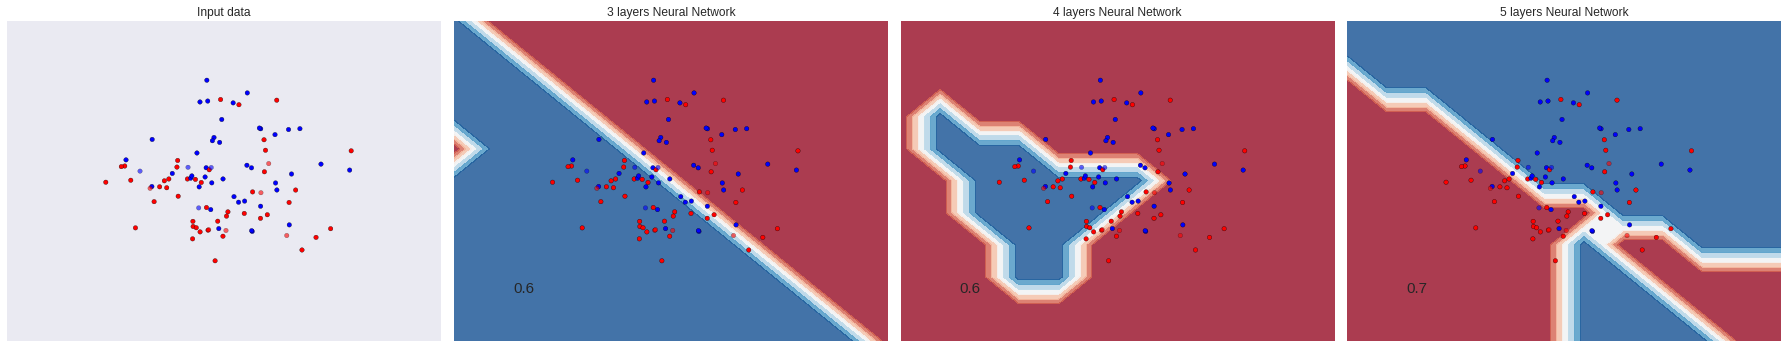

In [39]:
X_train, X_test, Y_train, Y_test, train_label, test_label = train_test_split(X_original, output_entropy, label_dataset, test_size = split_test)

step = 0.2
i = 1
figure = plt.figure(figsize = (25, 5))

titles = ['3 layers Neural Network', '4 layers Neural Network', '5 layers Neural Network']

scores = [accuracy_3layers, accuracy_4layers, accuracy_5layers]

neural_network = [three_layer_feed_2, four_layer_feed_3, five_layer_feed_4]

x_min, x_max = X_original[:, 0].min() - 0.5, X_original[:, 0].max() + 0.5
y_min, y_max = X_original[:, 1].min() - 0.5, X_original[:, 1].max() + 0.5
    
xx, yy = np.meshgrid(np.arange(x_min, x_max, step), np.arange(y_min, y_max, step))
    
cm = plt.cm.RdBu
cm_bright = ListedColormap(['#FF0000', '#0000FF'])
ax = plt.subplot(1, 4, i)
    
ax.set_title('Input data')
    
ax.scatter(X_train[:, 0], X_train[:, 1], c = train_label, cmap = cm_bright)
ax.scatter(X_test[:, 0], X_test[:, 1], c = test_label, cmap = cm_bright, alpha = 0.6)
    
ax.set_xlim(xx.min(), xx.max())
ax.set_ylim(yy.min(), yy.max())
ax.set_xticks(())
ax.set_yticks(())
i += 1

for score, name, net in zip(scores, titles, neural_network):
    ax = plt.subplot(1, 4, i)
    contour = np.c_[xx.ravel(), yy.ravel()].astype(np.float32)
    Z = sess.run(tf.nn.softmax(net), feed_dict = {X: contour})
    temp_answer = []
    for q in xrange(Z.shape[0]):
        temp_answer.append(np.argmax(Z[q]))
    Z = np.array(temp_answer)
    Z = Z.reshape(xx.shape)
    
    ax.contourf(xx, yy, Z, cmap = cm, alpha = 0.8)
    
    ax.scatter(X_train[:, 0], X_train[:, 1], c = train_label, cmap = cm_bright)
    ax.scatter(X_test[:, 0], X_test[:, 1], c = test_label, cmap = cm_bright, alpha = 0.6)
        
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_xticks(())
    ax.set_yticks(())
    ax.set_title(name)
    ax.text(xx.min() + 0.3, yy.min() + 0.3, str(score), size = 15)
        
    i += 1
            
plt.tight_layout()
plt.savefig('neuralnet_comparison.pdf')
plt.savefig('neuralnet_comparison.png')
plt.show()